# Regresión con KNN

En este notebook vamos a trabajar con KNN, pero desde el punto de vista de un problema de regresión. Vamos a comprar intuitivamente los resultados con los obtenidos con regresión lineal, y buscar evidenciar ventajas y desventajas.

Vamos a trabajar con la base de datos de caras Olivetti. La base de datos cuenta con 400 fotografías (10 fotografías de 40 sujetos distintos). Las 10 fotografías de cada sujeto contienen ligeras variaciones (muecas, iluminación, expresiones faciales, con o sin anteojos, etc). Las imagenes son de 64 $\times$ 64.

Primero importamos las librerias que vamos a usar, y cargamos el dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces # para cargar el dataset de caras
from sklearn.utils.validation import check_random_state # para tirar numeros al azar con semilla
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

data, targets = fetch_olivetti_faces(return_X_y=True) # cargamos las caras
print(data.shape) # dimensiones del dataset (las caras ya estan en forma de vector)
print(targets.shape) # dimensiones de la etiqueta (un numero distinto por sujeto)
print(targets) # etiquetas

train = data[targets < 30] # seleccionamos los sujetos con targets menores y mayores a 30 para train y test
test = data[targets >= 30]  # esto nos asegura entrenar y evaluar en personas diferentes
print(test.shape[0])



downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\bruno\scikit_learn_data
(400, 4096)
(400,)
[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9
  9  9  9  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 14 14 14 14
 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16
 16 16 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21
 21 21 21 21 22 22 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23
 24 24 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 26 26 26 26
 26 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27 28 28 28 28 28

Vamos a visualizar un poco las caras, ploteando 25 de ellas al azar

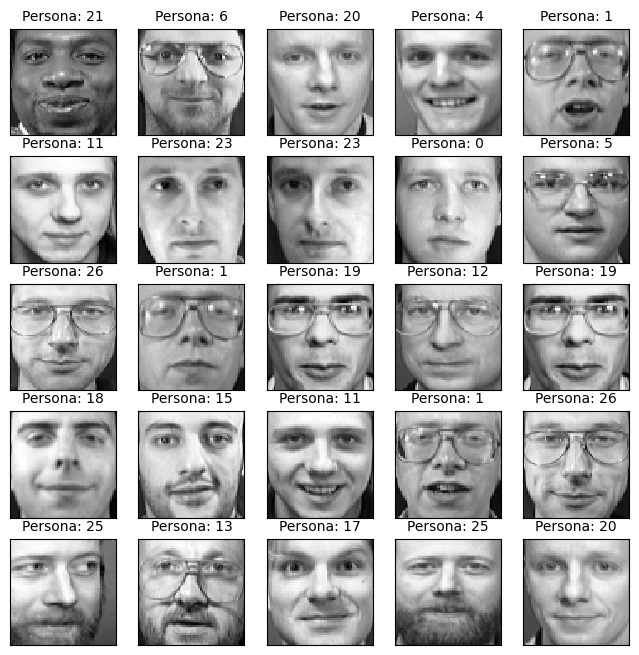

In [2]:
# Ploteo 25 imagenes al azar
fig = plt.figure(figsize = (8,8)) # seteo el tamano de la figura
for i in range(25):
    j = np.random.randint(0, train.shape[0]) # en cada iteracion elijo un numero random entre 0 y la longitud de train_raw
    plt.subplot(5,5,i+1) # Voy a tener una matriz de 5x5 subplots y voy llenando en la iteracion i-esima el subplot i+1
    plt.imshow(data[j,:].reshape(64,64), interpolation='none', cmap="gray") # plotea una imagen random, pues es la imagen j-esima del set de entrenamiento, en formato (28,28) para imagenes en escala de grises (tengo que reshapear)
    plt.title("Persona: {}".format(targets[j]), fontsize = 10) # pongo el titulo a los plots con el identificador unico de la persona
    plt.xticks([]) # le saco los ticks en el eje X
    plt.yticks([]) # le saco los ticks en el eje Y
plt.show()


Vamos a elegir un conjunto de 5 caras del conjunto de evaluacion para poder visualizarlas mejor.

In [3]:
n_faces = 5 # numero de caras a visualizar
rng = check_random_state(40393) # esto arma un generador de numeros aleatorios con una semilla
face_ids = rng.randint(test.shape[0], size=(n_faces, )) # genera el vector de indices de longitud 5
print(face_ids)
test = test[face_ids, :] # extrae las 5 caras


[27 95 76 49 60]


El problema que con el que vamos a trabajar es el de **completar caras**.

Vamos a entrenar modelos de regresion con el set de entrenamiento que tomen como input la mitad superior de la imagen y den como output la mitad inferior.

Luego, le damos la mitad superior de cada una de las 5 caras que elegimos para la visualizacion, y vemos como da el resultado.

Primero separo las mitades de las imagenes.

In [4]:
n_pixels = data.shape[1] # numero de pixeles de lado
print(n_pixels)
X_train = train[:, :(n_pixels + 1) // 2] # mitad superior como features para train
y_train = train[:, n_pixels // 2:] # mitad inferior como etiquetas para train
X_test = test[:, :(n_pixels + 1) // 2] # mitad superior como features para test
y_test = test[:, n_pixels // 2:]# mitad inferior como etiquetas para test

4096


Ahora armo un regresor KNN con parametros por defecto y predigo la parte inferior de las imagenes.

Luego, hago lo mismo con el regresor lineal.

In [5]:
# regresor KNN
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
y_test_knn = knn.predict(X_test)

# regresor lineal
lr = LinearRegression()
lr.fit(X_train, y_train)
y_test_lr = lr.predict(X_test)

Veamos las caras de testeo completas.

Caras originales


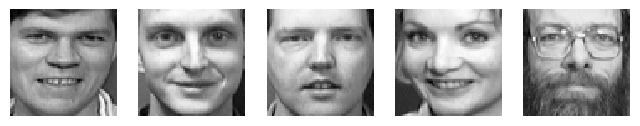

In [6]:
image_shape = (64, 64) # forma de la imagen

print('Caras originales')

fig = plt.figure(figsize = (8,8)) # seteo el tamano de la figura
for i in range(n_faces):
    true_face = np.hstack((X_test[i], y_test[i])) # compongo la parte superior con la inferior (original)
    plt.subplot(1,5,i+1)
    plt.axis("off")
    plt.imshow(true_face.reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest") # ploteo


Veamos las caras completadas con regresion KNN

Completado con KNN


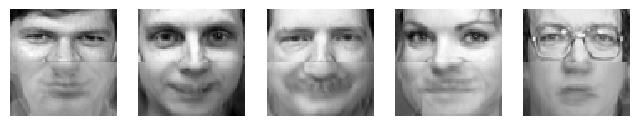

In [7]:
print('Completado con KNN')

fig = plt.figure(figsize = (8,8)) # seteo el tamano de la figura
for i in range(n_faces):
    completed_face = np.hstack((X_test[i], y_test_knn[i])) # compongo la parte superior con la inferior (original)
    plt.subplot(1,5,i+1)
    plt.axis("off")
    plt.imshow(completed_face.reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest") # ploteo


Veamos las caras completadas con regresion lineal.

Completado con regresión lineal


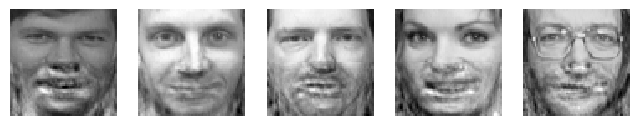

In [8]:
print('Completado con regresión lineal')


fig = plt.figure(figsize = (8,8)) # seteo el tamano de la figura
for i in range(n_faces):
    completed_face = np.hstack((X_test[i], y_test_lr[i]))
    plt.subplot(1,5,i+1)
    plt.axis("off")
    plt.imshow(completed_face.reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest")


Una caracteristica de la prediccion con KNN es que proviene del promedio de caras existentes. Por lo tanto, la complecion tiene tendencia a tener aspecto de cara. Mientras que en la regresion lineal hay una extrapolacion en juego que puede salirse del "espacio" de caras posibles, dando predicciones que no tienen mucha forma de caras.

# Para llevarse de este notebook

Podemos hacer una regresion basada en instancias con KNN usando:


```
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
y_test_knn = knn.predict(X_test)
```

Las ventajas comparativas con otros metodos son similares para el caso de la clasificacion con KNN.




# Para hacer


*   Probar meter regularizacion en el modelo de regresion lineal. ¿Mejora esto las predicciones?
*   Cambiar los parametros del regresor KNN y explorar que pasa
*   ¿Como es la robustez de un regresor KNN ante outliers?
*   ¿Puede overfittear un regresor KNN? ¿Tiene sentido hablar de regularizacion?




